In [1]:
import random
import time
import numpy as np
import torch
import torch.autograd
from torch.autograd import Variable
import pandas as pd
import os
from utils.file_utils import *
import json
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from IPython import get_ipython
get_ipython().run_line_magic("load_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")

from datasets import load_dataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset("imdb")

Reusing dataset imdb (/tmp/xdg-cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)


In [3]:
train_batch = dataset['train']['text']
train_labels = torch.tensor(dataset['train']['label'])

In [4]:
val_batch = dataset['test']['text']
val_labels = torch.tensor(dataset['test']['label'])

In [5]:
val_batch = val_batch[:10000]
val_labels = torch.tensor(val_labels[:10000])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [6]:
from transformers import  BartTokenizer

In [7]:
# Load the BART tokenizer.
print('Loading BART tokenizer...')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

Loading BART tokenizer...


In [8]:
vocab_size = tokenizer.vocab_size

In [9]:
seq_length = 150
input_encoding = tokenizer(train_batch, return_tensors='pt', padding=True, truncation = True, max_length=seq_length)

In [10]:
val_encoding = tokenizer(val_batch, return_tensors='pt', padding=True, truncation = True, max_length=seq_length)

In [11]:
input_ids = input_encoding['input_ids']
input_mask = input_encoding['attention_mask']

In [12]:
val_ids = val_encoding['input_ids']
val_mask = val_encoding['attention_mask']

In [13]:
input_ids.shape, input_mask.shape, val_ids.shape, val_mask.shape

(torch.Size([25000, 150]),
 torch.Size([25000, 150]),
 torch.Size([10000, 150]),
 torch.Size([10000, 150]))

In [14]:
# Creating DataLoaders

# TRAINNG DATALOADER
batch_size = 64

train_data = TensorDataset(input_ids, input_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [15]:
# VALIDATION DATALOADER

val_data = TensorDataset(val_ids, val_mask, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [33]:
from ClassifierModel import ClassifierModel
import json

In [34]:
embedding_dim = 64
out_dim = 2
n_layers = 4
hidden_size = 512
model_name = 'classifier_n4'
model_dir = './experiment'
model_path = os.path.join(model_dir,model_name)

In [35]:
config = {
    'embedding_dim': embedding_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'hidden_size': hidden_size,
    'model_name': model_name
}

In [36]:
clf = ClassifierModel(vocab_size,
                      embedding_dim,
                      out_dim,
                      n_layers,
                      hidden_size)
clf

ClassifierModel(
  (embedding): Embedding_(
    (embedding): Embedding(50265, 64)
  )
  (lstm): LSTM(64, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [37]:
loss_fn = torch.nn.CrossEntropyLoss()

In [38]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [39]:
clf.to(0)

ClassifierModel(
  (embedding): Embedding_(
    (embedding): Embedding(50265, 64)
  )
  (lstm): LSTM(64, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [42]:
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False, model_dir='./experiment',config = None):
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    min_val_loss = np.inf
    
    model_name = config['model_name']
    
    if not os.path.exists(os.path.join(model_dir,model_name)):
        os.mkdir(os.path.join(model_dir,model_name))
    model_path = os.path.join(model_dir,model_name)
    
    train_log =  'train_log.txt'
    val_log = 'val_log.txt'
    
    write_to_file_in_dir(model_path, 'config.json', config)
    print(f"Start training for Model {model_name}...\n")
    write_string_train = f"Epoch, Train_Loss, Train_Acc"
    write_string_val = f"Epoch, Val_Loss, Val_Acc"
    
    log_to_file_in_dir(model_path, train_log, write_string_train)
    log_to_file_in_dir(model_path, val_log, write_string_val)
    
    
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        optimizer = torch.optim.Adam(model.parameters())
        
        for step, batch in enumerate(train_dataloader):
            model.train()
            batch_counts +=1
            
            b_input_ids, b_labels = batch[0].to(0), batch[2].to(0)
            model.zero_grad()

            logits = model(b_input_ids)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            
            train_losses.append(loss.item())
            
            preds = torch.argmax(logits, dim=1).flatten()

            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            train_accs.append(accuracy)
            write_string_train = f"{epoch_i}, {loss.item()}, {accuracy}"
            log_to_file_in_dir(model_path, train_log, write_string_train)
            
            
            loss.backward()

            optimizer.step()

            if (step % 100 == 0 and step != 0):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

                print("-"*70)

        if ((epoch_i %20 ==0) and (epoch_i != 0)) or (epoch_i==epochs-1):
            if evaluation == True:
                val_loss, val_accuracy = evaluate(model, val_dataloader)
                val_losses.append(val_loss)
                val_accs.append(val_accuracy)
                
                write_string_val = f"{epoch_i}, {val_loss}, {val_accuracy}"
                log_to_file_in_dir(model_path, val_log, write_string_val)
                
                time_elapsed = time.time() - t0_epoch
                
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    
                    torch.save(model, os.path.join(model_path, f'{model_name}.pt'))
                    
                print(f"{epoch_i + 1:^7} | {'-':^7} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
    torch.save(model, os.path.join(model_path,f'{model_name}_final.pt'))
        
    return  train_losses, train_accs, val_losses,val_accs

In [43]:
def evaluate(model, val_dataloader):

    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        
        b_input_ids, b_labels = batch[0].to(0), batch[2].to(0)
        with torch.no_grad():
            logits = model(b_input_ids)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
stats = train(clf, train_dataloader, val_dataloader=val_dataloader, epochs=100, evaluation=True,  config=config)

Start training for Model classifier_n4...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   100   |   0.781759   |     -      |     -     |   13.84  
----------------------------------------------------------------------
   1    |   200   |   0.611784   |     -      |     -     |   12.68  
----------------------------------------------------------------------
   1    |   300   |   0.554272   |     -      |     -     |   12.51  
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   100   |   0.438064   |     -      |     -     |   17.47  
----------------------------------------------------------------------
   2    |   200   |   0.424780   |     -      |     -     |   15.45  
-----------------------------------------

In [26]:
train_losses, train_accs, val_losses,val_accs = stats

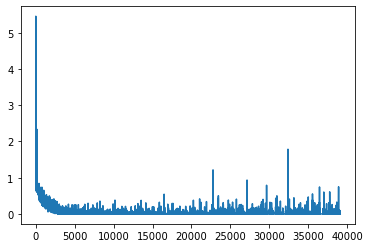

In [27]:
plt.plot(np.arange(len(train_losses)), np.array(train_losses))

In [28]:
write_string = f"{train_losses[0]} {train_accs[0]}"

write_string

'0.8470673561096191 43.75'

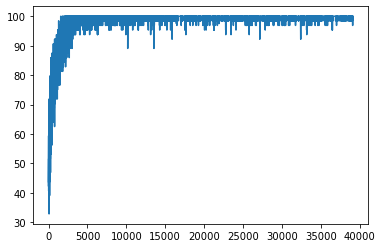

In [29]:
plt.plot(np.arange(len(train_accs)), np.array(train_accs))

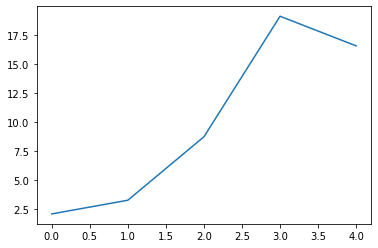

In [30]:
plt.plot(np.arange(len(val_losses)), np.array(val_losses))

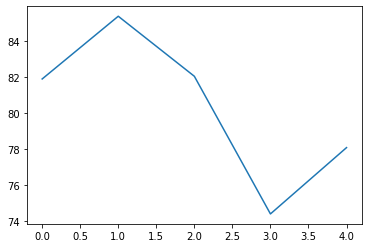

In [31]:
plt.plot(np.arange(len(val_accs)), np.array(val_accs))

# ---------- Testing differentiability ----------------

b[0].shape

b_dash = torch.randn((4,47, vocab_siz

b_dash = torch.randn((4,47, vocab_size))

a = torch.nn.Parameter(torch.zeros_like(b_dash).float() +1 )

c = 2*a

c.shape

idx =  torch.argmax(c, dim=-1, keepdims=  True)

mask = torch.zeros_like(c).scatter_(-1, idx, 1.).float().detach() + c - c.detach()

o1 = clf(mask)

mse = torch.nn.MSELoss()

z = mse(o1, torch.zeros_like(o1))

torch.autograd.grad(z, a)

# ---------------------- Fin ----------------------------